In [1]:
from time import sleep

import numpy as np
import scipy.io
from scipy.signal import resample
from sklearn.cluster import KMeans
from sklearn.decomposition import SparseCoder

%matplotlib notebook
from tqdm.notebook import trange
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

# GAN

_Objective_ : Create new sequences from human movements.

## Display

We use 3D plot from matplotlib and mpl_toolkits. Each skeleton part is a plot which appears as a line.

In [2]:
links = [
    (1, 2), (2, 3), (2, 4), (2, 7),
    (4, 5), (5, 6), (7, 8), (8, 9),
    (3, 10), (3, 13), (10, 11),
    (11, 12), (13, 14), (14, 15)
]

links = [(i-1, j-1) for i, j in links] # Thx Matlab and your index starting at 1

def display_skt(sklt):
    """
    Display one skeleton
    
    @param sklt: matrix with a shape of (15, 3), 15 3D points
    """
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.axis("off")
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.set_zlim(0, 2)
    
    for link in links:
        # [start, end]
        x = [sklt[link[0]][0], sklt[link[1]][0]]
        y = [sklt[link[0]][1], sklt[link[1]][1]]
        z = [sklt[link[0]][2], sklt[link[1]][2]]
        ax.plot3D(x, y, z, color="green")
    plt.show()

def display_seq(sequence):
    """
    Display many skeletons
    
    @param sklt: matrix with a shape of (n, 15, 3), n skeletons of 15 3D points
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')    
    plt.ion()
    fig.show()
    for sklt in sequence:
        ax.clear()
        ax.axis("off")
        sklt -= np.mean(sklt, axis=0)[np.newaxis, :]
        ax.set_xlim(0, 2)
        ax.set_ylim(0, 2)
        ax.set_zlim(0, 2)
        
        for link in links:
            # [start, end]
            x = [sklt[link[0]][0], sklt[link[1]][0]]
            y = [sklt[link[0]][1], sklt[link[1]][1]]
            z = [sklt[link[0]][2], sklt[link[1]][2]]
            ax.plot3D(x, y, z, color="green")
        fig.canvas.draw()
        sleep(0.1)

# Data loading

The data is stored in a matlab structure file.

In [3]:
skltons = scipy.io.loadmat('Data/sequences.mat')["sequences"][0]

# Data augmentation

The dataset is very small only 4016 skeletons in 214 sequences. So, duplicate skeletons along y-axis and reduce dimensions

<IPython.core.display.Javascript object>


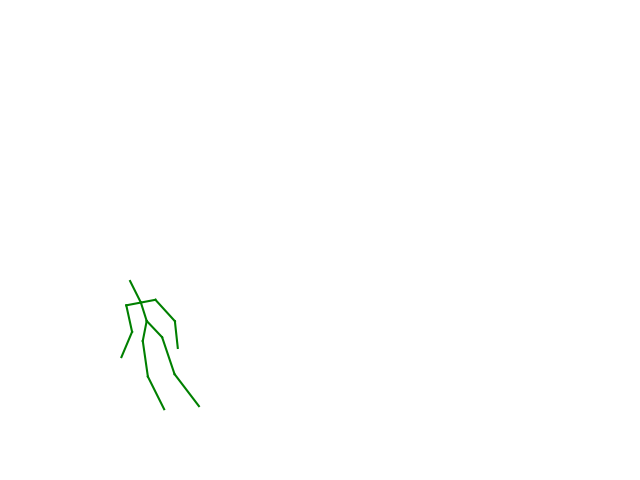

<IPython.core.display.Javascript object>


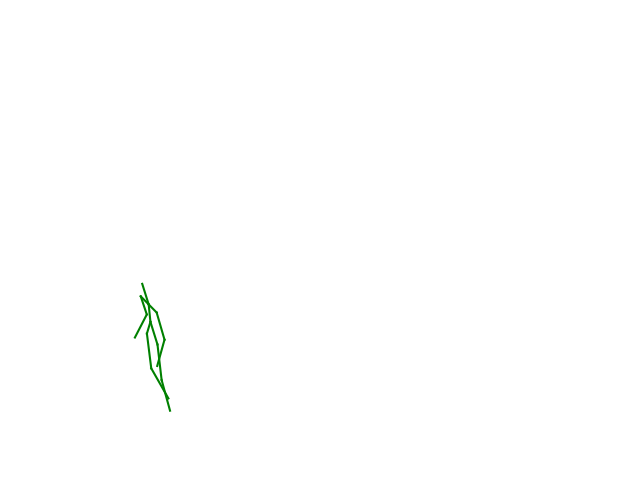

(4016, 15, 3)
(8032, 15, 3)


In [4]:
all_skltons = []
for sklton in skltons:
    all_skltons += [*sklton]
    
all_skltons = np.array(all_skltons)
all_skltons_y_flip = all_skltons.copy()
all_skltons_y_flip[:, :, 0] = all_skltons_y_flip[:, :, 1]
all_skltons_y_flip[:, :, 1] = all_skltons_y_flip[:, :, 0]

display_seq(all_skltons_y_flip[-25:])
display_seq(all_skltons[-25:])

print(all_skltons.shape)
all_skltons = np.vstack([all_skltons, all_skltons_y_flip])
print(all_skltons.shape)

# Pre-processing

The data is time series but for GAN, the data must be a vector with the same shape all the time.
Also we reduce the dimension of a skeleton with clustering and a sparse coder.

In [5]:
# flatten for clustering
n_samples = all_skltons.shape[0]
all_skltons_flat = all_skltons.reshape(n_samples, -1)
print(all_skltons_flat.shape)

(8032, 45)


In [6]:
# data encoder creation
n_clusters = 20
kmeans = KMeans(n_clusters= n_clusters).fit(all_skltons_flat)
coder = SparseCoder(kmeans.cluster_centers_, transform_n_nonzero_coefs=None)
wei = coder.transform(all_skltons_flat)

In [7]:
# for sklt in kmeans.cluster_centers_:
#     display_skt(sklt.reshape(15, 3))

In [8]:
# check distance between original skeletons and reconstructed skeletons
reconstructed = wei.dot(kmeans.cluster_centers_)
dist = np.linalg.norm(all_skltons_flat-reconstructed)
print(dist/n_samples)

0.005607577401132035


In [9]:
print(np.mean(skltons[0], axis=1).shape)

(27, 3)


In [10]:
# transform data with encoders

time_iter = 20
sequence = []

for sklton in skltons:
    time_iter_sk = sklton.shape[0]
    # copy to flip
    sklton_y_flip = sklton.copy()
    sklton_y_flip[:, :, 0] = sklton_y_flip[:, :, 1]
    sklton_y_flip[:, :, 1] = sklton_y_flip[:, :, 0]
    
    for sklt in [sklton, sklton_y_flip]:
        # flat
        sklt = sklt.reshape(time_iter_sk, -1)
        # format to the same time series length
        sklt = resample(sklt, time_iter)
        # clustering and sparse encoder
        sklt = coder.transform(sklt)
        sequence.append(sklt)
    
sequence = np.array(sequence)
print(sequence.shape)

(430, 20, 20)


code forked from https://github.com/lyeoni/pytorch-mnist-GAN

# NN

Simple Gan with only basic neurons.

In [11]:
dim_sk = time_iter*n_clusters
z_dim = 32
batch_size = 215

In [12]:
class SkeltonDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data.astype('float'))
        self.shape = data[0].shape
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Add some noise
        data_val = self.data[index] + torch.randn(*self.shape) * 0.05
        return data_val, 0

In [13]:
train_dataset = SkeltonDataset(sequence)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [14]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 64)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, dim_sk)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [15]:
G = Generator(g_input_dim = z_dim, g_output_dim = dim_sk)
D = Discriminator(dim_sk)

In [16]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0001
G_optimizer = optim.AdamW(G.parameters(), lr = lr)
D_optimizer = optim.AdamW(D.parameters(), lr = lr)

In [17]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, dim_sk), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real), Variable(y_real)

    D_output = D(x_real)
    dx = D_output
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(batch_size, z_dim))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1))

    D_output = D(x_fake)
    dgz = D_output
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item(), torch.mean(dx), torch.mean(dgz)

In [18]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim))
    y = Variable(torch.ones(batch_size, 1))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [19]:
n_epoch = 5000
for epoch in trange(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        d_loss, dx, dgz = D_train(x)
        D_losses.append(d_loss)
        G_losses.append(G_train(x))
    if epoch % 200 == 0:
        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f, G(x): %.3f, G(D(z)): %.3f' % (
                (epoch), n_epoch,
                torch.mean(torch.FloatTensor(D_losses)),
                torch.mean(torch.FloatTensor(G_losses)),
                dx, dgz
        ))

[200/5000]: loss_d: 0.310, loss_g: 2.349, G(x): 0.881, G(D(z)): 0.153
[400/5000]: loss_d: 0.505, loss_g: 2.306, G(x): 0.826, G(D(z)): 0.172
[600/5000]: loss_d: 0.324, loss_g: 3.344, G(x): 0.892, G(D(z)): 0.100
[800/5000]: loss_d: 0.255, loss_g: 4.140, G(x): 0.924, G(D(z)): 0.094
[1000/5000]: loss_d: 0.267, loss_g: 3.545, G(x): 0.919, G(D(z)): 0.106
[1200/5000]: loss_d: 0.500, loss_g: 3.427, G(x): 0.894, G(D(z)): 0.153
[1400/5000]: loss_d: 0.384, loss_g: 3.007, G(x): 0.864, G(D(z)): 0.138
[1600/5000]: loss_d: 0.394, loss_g: 3.339, G(x): 0.854, G(D(z)): 0.118
[1800/5000]: loss_d: 0.352, loss_g: 3.210, G(x): 0.913, G(D(z)): 0.146
[2000/5000]: loss_d: 0.356, loss_g: 2.910, G(x): 0.886, G(D(z)): 0.126
[2200/5000]: loss_d: 0.625, loss_g: 3.166, G(x): 0.852, G(D(z)): 0.158
[2400/5000]: loss_d: 0.523, loss_g: 3.084, G(x): 0.848, G(D(z)): 0.146
[2600/5000]: loss_d: 0.355, loss_g: 3.303, G(x): 0.897, G(D(z)): 0.098
[2800/5000]: loss_d: 0.435, loss_g: 3.223, G(x): 0.873, G(D(z)): 0.142
[3000/5000

# Generation

Create some skeleton sequences and display them

In [20]:
with torch.no_grad():
    test_z = Variable(torch.randn(batch_size, z_dim))
    generated = G(test_z).numpy()

<IPython.core.display.Javascript object>


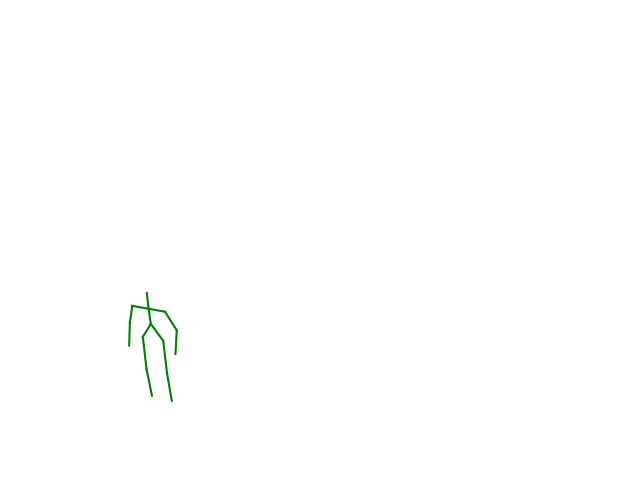

In [22]:
full_seq = []
for seq in generated:
    seq = seq.reshape(time_iter, n_clusters)
    seq = seq.dot(kmeans.cluster_centers_)
    seq = seq.reshape(-1, 15, 3)
    full_seq += [*seq]
    
full_seq = np.array(full_seq)
display_seq(full_seq[:50])